# Notebook setup

## Import basic libraries

In [1]:
import os
import sys
import numpy
import json
import subprocess
import operator
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_style('darkgrid')

from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from setup_geometry_interactions_db import \
    Json,Tags,RigidBody,RadialProfiles,Miscellaneous,Interhelix_Interactions, Base

> _NOTE_ Make sure that you install `requirements.txt`

## Initialise database session

In [3]:
dbfile = 'mutants_docked_geometry-interactions.db'
engine = create_engine('sqlite:///'+dbfile)
Base.metadata.bind = engine
DBSession = sessionmaker()
DBSession.bind = engine
session = DBSession()

# Pore conformation analysis

Base function

In [4]:
def compute_radial_metrics(profile_Y, metric):
    """
    Function to compute several metrics given a radial profile of a symmetric docking model.
    
    Parameters
    ----------
    profile_Y : ndarray, shape(n,)
        radial profile.
        
    metric: string
        metric name to be measured from given radial profile.
    
    Returns
    -------
        value (float) of selected metric
    """
    if metric == 'length':
        return max(profile_Y) - min(profile_Y)
    
    elif metric == 'mean':
        return numpy.mean(profile_Y)
    
    elif metric == 'std':
        return numpy.std(profile_Y)
    
    elif metric == 'cv':
        return numpy.std(profile_Y)/numpy.mean(profile_Y)
    
    elif metric == 'min':
        return min(profile_Y)
    
    elif metric == 'max':
        return max(profile_Y)

Measure all _Euler angles_ and _profile metrics_ for all mutant models, from their primitive and vdW radial profiles.

In [2]:
mutant_names = ['cWza','cWza-K375C','cWza-S355C','cWza-Y373C']

In [5]:
S_mutants = {} # dict for data storage
metrics = ['length','mean','std','cv','min','max']

for i in range(len(mutant_names)):
    mutant = mutant_names[i]
    S_mutants[mutant] = {} 
    group = 'None' # if model tagged
    Theta = []; Psi = []; Phi = [] # Euler angles lists
    
    model_ids = [x[0] for x in session.query(Tags.id).filter_by(mutant = mutant)]
    
    # Create lists for radial metrics
    for j in range(len(model_ids)):
        id = model_ids[j]
        
        # Euler angles: mean values for all chains
        euler_angles_all = session.query(RigidBody.euler_angles).filter_by(id = id).all()[0][0]
        euler_angles = {
            'tilt' : numpy.mean(euler_angles_all[0]),
            'interchain' : numpy.mean(euler_angles_all[1]),
            'facing' : numpy.mean(euler_angles_all[2])
            }
        
        # Primitive profiles: radial and length metrics
        primitive_profile = session.query(RadialProfiles.primitive).filter_by(id = id).all()[0][0]
        X, Y = primitive_profile
        primitive_R_metrics = {}
        
        for key in metrics:
            if key != 'length':
                S = Y # radial coordinates
            else:
                S = X # longitudinal coords
            primitive_R_metrics[key] = compute_radial_metrics(S, key)
        
        # VdW profiles: radial and length metrics
        vdw_profile = session.query(RadialProfiles.vdw_aa_lower).filter_by(id = id).all()[0][0]
        X,Y = vdw_profile
        vdw_R_metrics = {} 
        
        for key in metrics:
            if key != 'length':
                S = Y
            else:
                S = X
            vdw_R_metrics[key] = compute_radial_metrics(S,key)
            
        # Overall data as single list
        model_data = {
            'euler angles': euler_angles,
            'primitive metrics': primitive_R_metrics,
            'vdw metrics': vdw_R_metrics
        }
        
        # Assign data dict according to model ID
        S_mutants[mutant][id] = model_data
        

/home/ba13026/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SAWarning: TypeDecorator Json() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.
  app.launch_new_instance()
/home/ba13026/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SAWarning: TypeDecorator Json() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.
/home/ba13026/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: SAWarning: TypeDecorator Json() will not produce a cache key because the ``cache_ok`` flag is not set to True.  Set this flag to True if this type object's state is safe to use in a cache key, or False to disable this warning.


Save data as JSON file. This file should accompany this Notebook by default. 

```python
with open('mutants_docked_geometry-interactions_profile-metrics.json', 'w') as fp:
    json.dump(S_mutants, fp)
```

## Plot raw data of pore dimensions  

From the above collection of measurements from all docking model we plot their pore dimensions, as given by the _minimum radius_ and the _lenght_ of their van der Waals profiles.

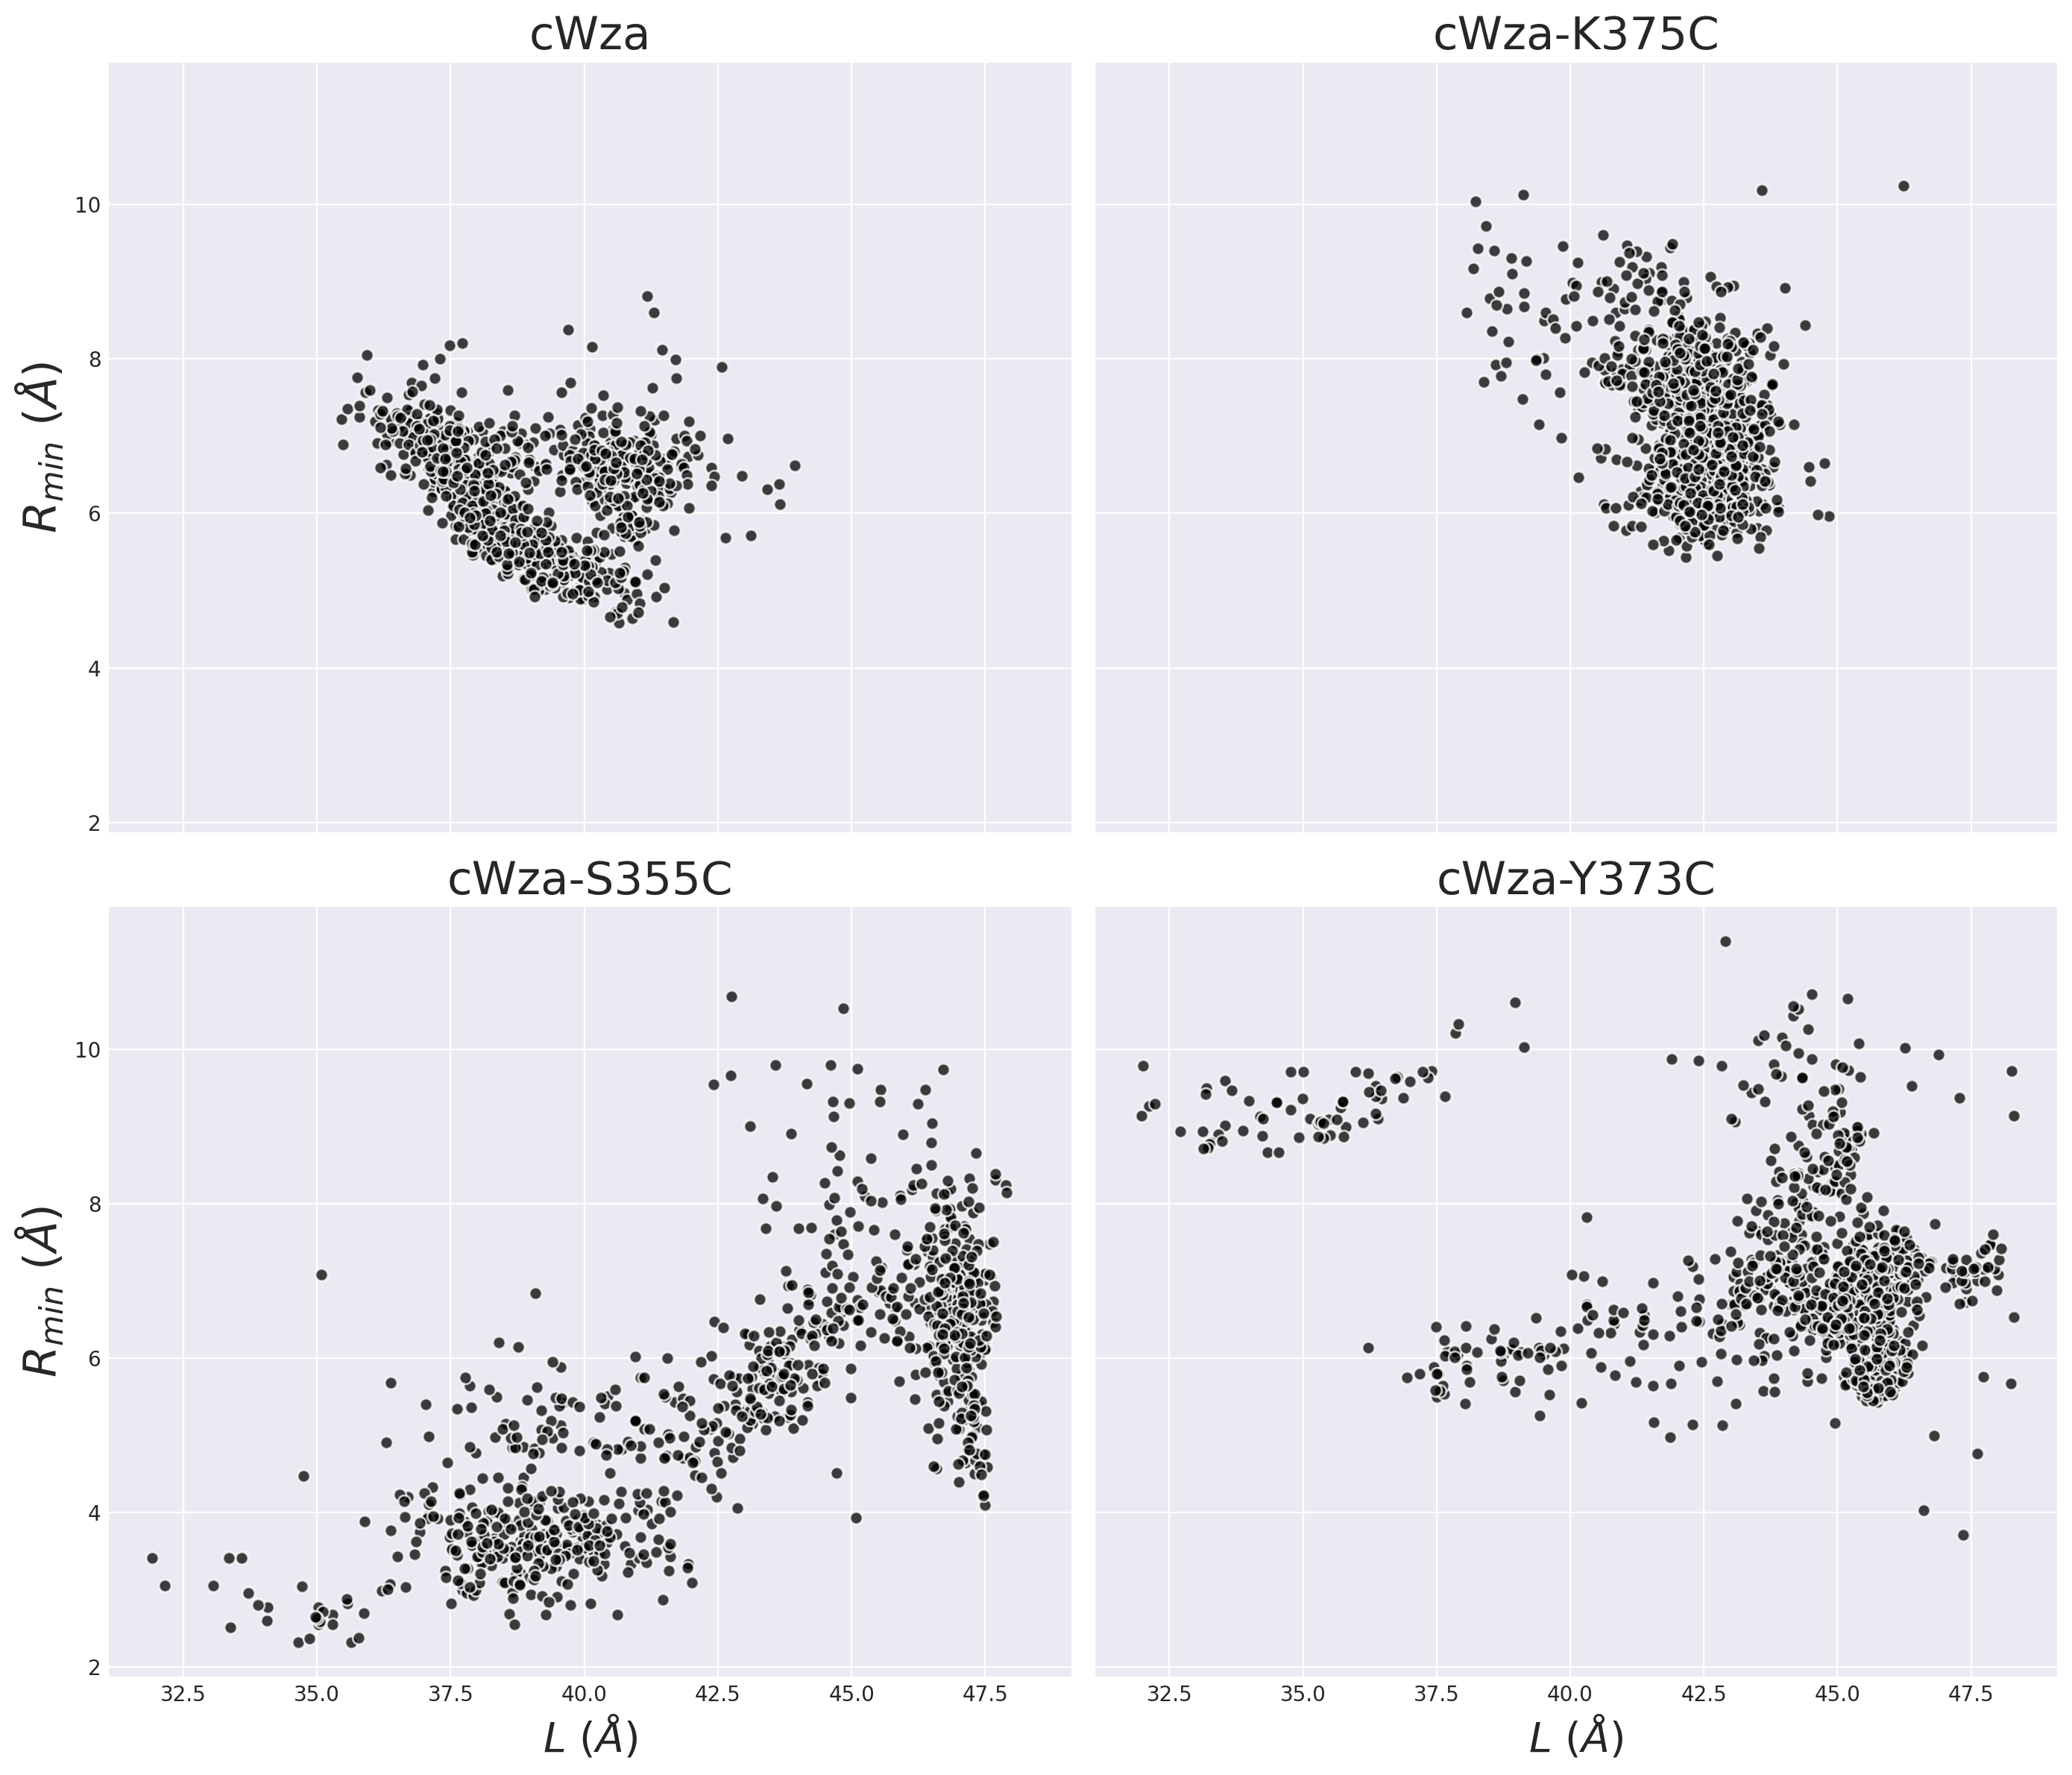

In [6]:
fig, ax = plt.subplots(2,2, figsize=(14, 12),dpi=200,sharex=True,sharey=True)
n_mutants = len(mutant_names)
import matplotlib

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

for i in range(n_mutants):
    
    # Select metric types to plot
    mutant = mutant_names[i]
    key11, key12 = 'vdw metrics','length'
    key21, key22 = 'vdw metrics','min'
    
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    # Plot raw data as scatter plot
    axes[mutant].scatter(X1, X2, color="black", edgecolor='white', alpha=0.75)
    
    # Customise plot
    axes[mutant].set_title(mutant, fontsize=22)
    axes[mutant].tick_params(axis='both',direction='in')
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=20)
    axes[mutant].set_ylabel(l2,fontsize=22)
    
# fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.show()

## Estimate PDFs and find local maxima

* The two-dimensional Probability Density Function (PDF) is estimated using *Gaussian Kernel Density Estimations (KDE)*

REF:

https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

* Local maxima for the estimated PDF are identified using `peak_local_max`, from `skimage` Python library for Image Processing. 

REF: 

http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.peak_local_max

http://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html

In [7]:
from scipy.stats import gaussian_kde
from scipy import ndimage as ndi
from skimage.feature import peak_local_max

def density_estimation(m1,m2):
    xmin=min(m1)
    xmax=max(m1)
    ymin=min(m2)
    ymax=max(m2)
    X, Y = numpy.mgrid[xmin:xmax:400j, ymin:ymax:400j]                                                     
    positions = numpy.vstack([X.ravel(), Y.ravel()])                                                       
    values = numpy.vstack([m1, m2])                                                                        
    kernel = gaussian_kde(values)                                                                 
    Z = numpy.reshape(kernel(positions).T, X.shape)
    return X,Y,Z

def find_maxima(X1,X2):
    X,Y,Z = list(density_estimation(X1,X2))
    # Find and filtre peaks by minimum pixel distance and fraction height glob-max
    coordinates = peak_local_max(Z, threshold_rel=0.5, min_distance=20)
    maxima = []
    for k in range(len(coordinates)):
        idx_0,idx_1 = coordinates[k]
        x_max, y_max = X[idx_0][0], Y[idx_0][idx_1]
        maxima.append((x_max, y_max))
    return maxima

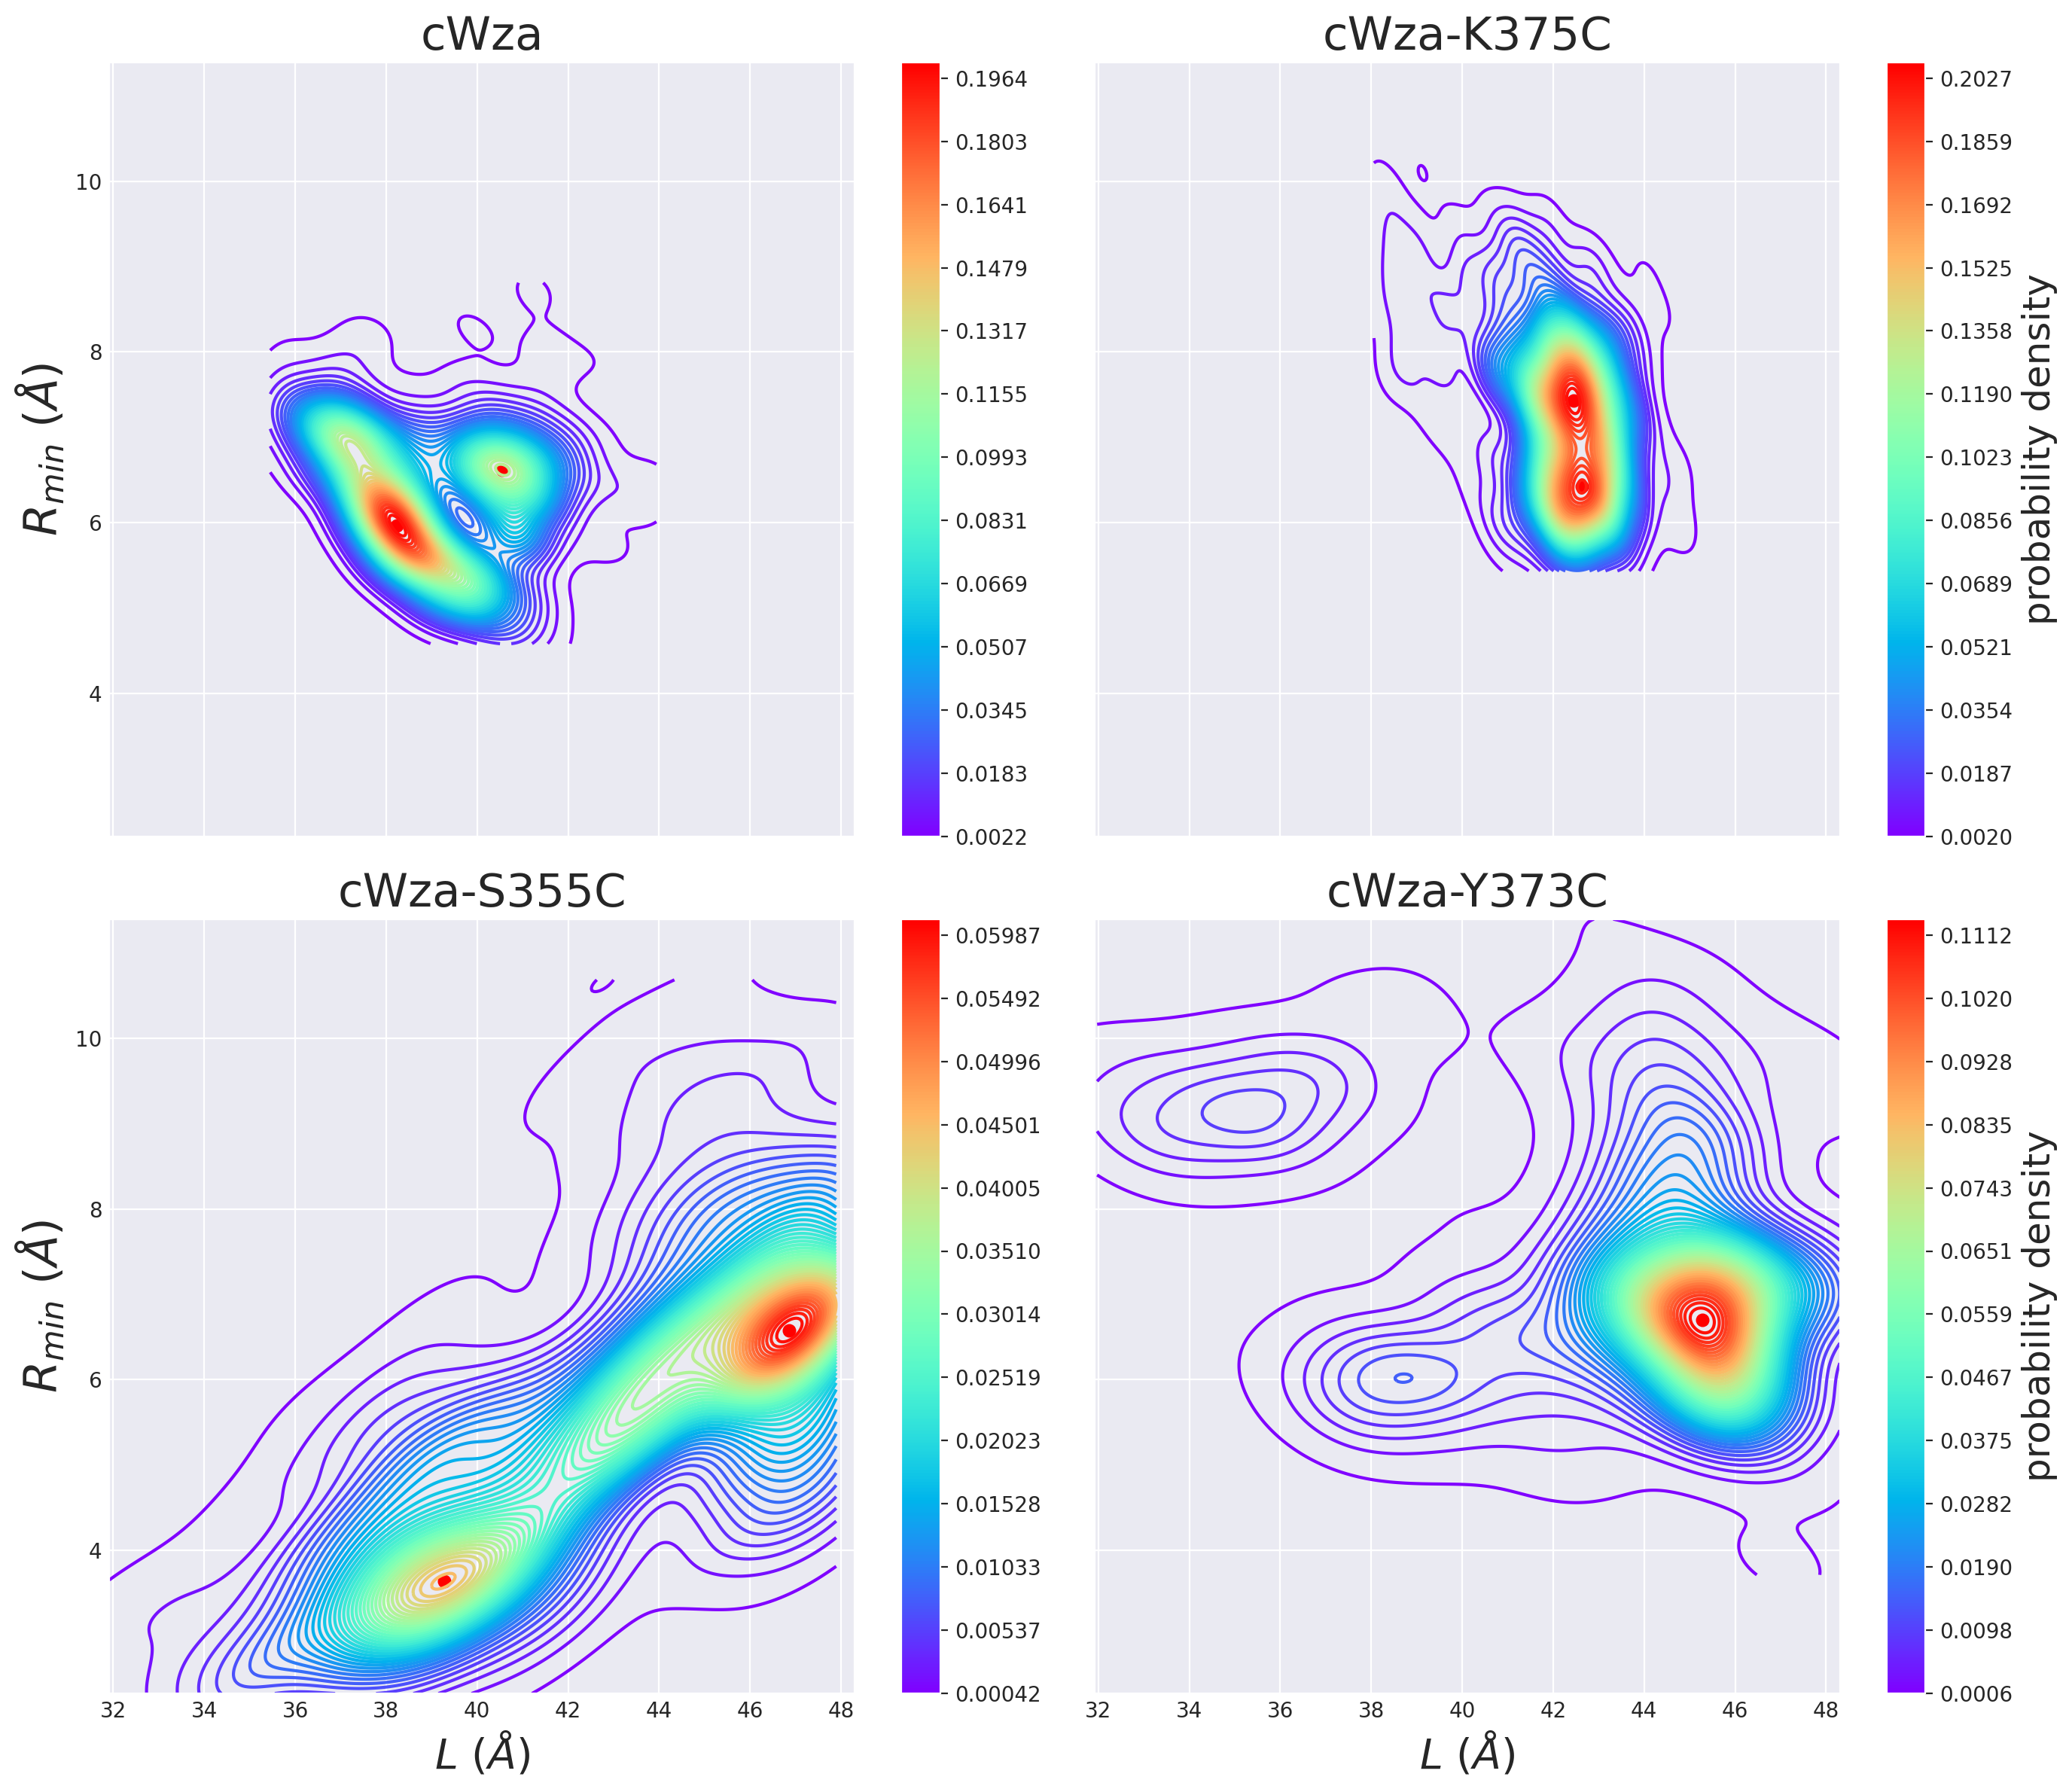

In [8]:
fig, ax = plt.subplots(2,2, figsize=(14,12),dpi=200,sharex=True,sharey=True)
n_mutants = len(mutant_names)
import matplotlib

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

maxima_mutants = {}

kde_mutants = {}

cmap = plt.get_cmap('rainbow')

for i in range(n_mutants):
    mutant = mutant_names[i]
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    
    ##############################################
    # Estimate PDF and set levels for contour plot
    ##############################################
    kde = gaussian_kde([X1,X2])
    kde_mutants[mutant] = kde
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = numpy.linspace(pdf_min, pdf_max,n_contours)
    
    ##############################################
    # Plot contour lines
    ##############################################
    Xc,Yc,Zc = list(density_estimation(X1,X2))
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,cmap=cmap)
    
    ##############################################
    # Colorbar: Continuous
    ##############################################
    norm= matplotlib.colors.Normalize(vmin=CS.cvalues.min(), vmax=CS.cvalues.max())
    SM = plt.cm.ScalarMappable(norm=norm, cmap = CS.cmap)
    SM.set_array([])
    CB = fig.colorbar(SM, ticks=CS.levels[::4], ax=axes[mutant])
    
    ##############################################
    #Find maxima and plot them
    ##############################################
    maxima = find_maxima(X1,X2)
    maxima_mutants[mutant] = maxima
    maxima = sorted(maxima, key=itemgetter(1)) # Sort maxima by VdW Rmin 
    for k in range(len(maxima)):
        x,y = maxima[k]
        axes[mutant].scatter(x, y, s=30, marker='o', color='red')
        
    ##############################################
    # Customise plot
    ##############################################
    axes[mutant].set_title(mutant, fontsize=22)
    axes[mutant].tick_params(axis='both',direction='in')
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=20)
    axes[mutant].set_ylabel(l2,fontsize=22)
    CB.set_label(l3,fontsize=18)

# fig.subplots_adjust(wspace=0.2)
plt.tight_layout()
plt.show()

In [9]:
Conformations = {}
for mutant in mutant_names:
    # Sort by VdW Rmin
    maxima_mutants[mutant] = sorted(maxima_mutants[mutant], key=itemgetter(1))
    if mutant != 'cWza-Y373C':
        Conformations[mutant] = {'Narrow': maxima_mutants[mutant][0], 'Wide': maxima_mutants[mutant][1]}
    else:
        Conformations[mutant] = {'Single': maxima_mutants[mutant][0]}

In [10]:
pd.DataFrame(Conformations,columns=mutant_names,index=['Narrow','Wide','Single'])

cWza  \
Narrow  (38.23883132127416, 5.969397599643297)   
Wide    (40.55824588450369, 6.616237989274787)   
Single                                     NaN   

                                     cWza-K375C  \
Narrow  (42.63091069654481, 6.4216403284226224)   
Wide    (42.446409367362236, 7.434207855310593)   
Single                                      NaN   

                                      cWza-S355C  \
Narrow      (39.283895799353, 3.639642630897556)   
Wide    (46.853206681267665, 6.5753407958330605)   
Single                                       NaN   

                                    cWza-Y373C  
Narrow                                     NaN  
Wide                                       NaN  
Single  (45.275025030717444, 6.69590032052864)

## Identify regions of high probability

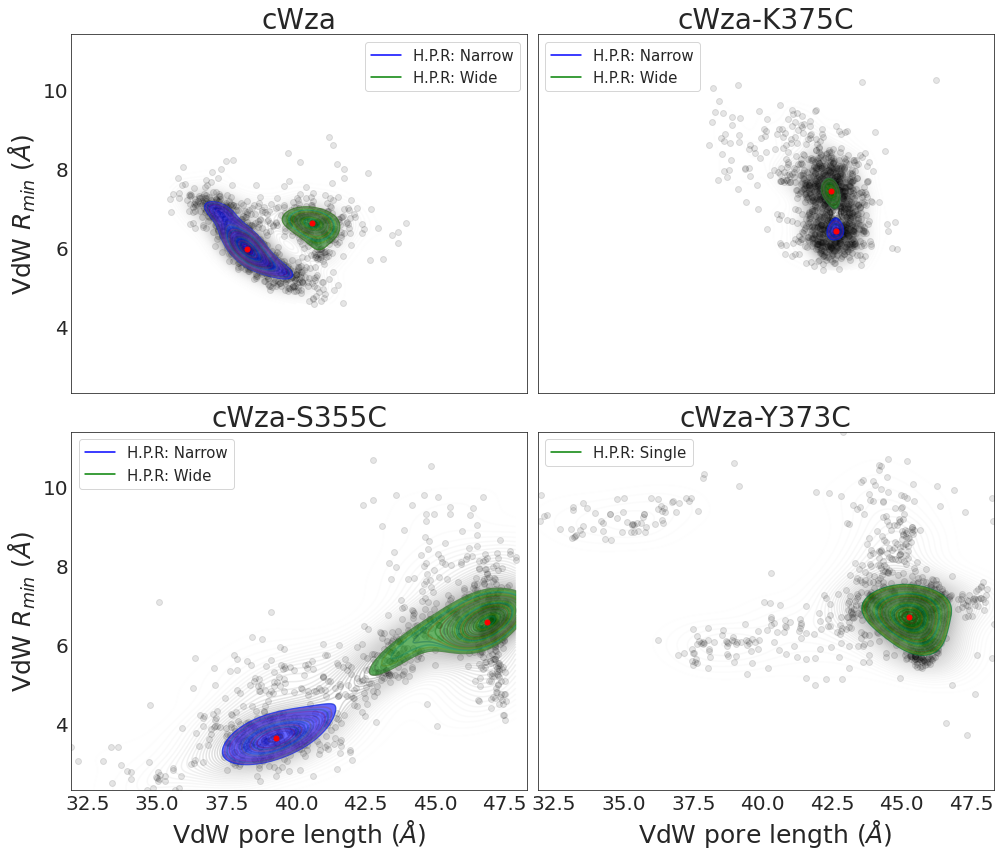

In [12]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

fig, ax = plt.subplots(2,2, figsize=(14,12),sharex=True,sharey=True)

axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","VdW $R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("VdW pore length ($\AA$)","VdW $R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("VdW pore length ($\AA$)","","probability density")
}

Conformations = {
    'cWza':['Narrow', 'Wide'],
    'cWza-K375C':['Narrow', 'Wide'],
    'cWza-S355C':['Narrow', 'Wide'],
    'cWza-Y373C':['Single']
}

Colors = {
    'Narrow': 'blue',
    'Wide': 'green',
    'Single': 'green'
}

Contours_filtred = {}
Contours_mutants = {}
ContoursProb_filtred = {}

ff = 0.5 # filtering factor

for i in range(n_mutants):
    mutant = mutant_names[i]
    Contours_filtred[mutant] = {}
    Contours_mutants[mutant] = []
    ContoursProb_filtred[mutant] = {}
    ###############################################
    # Extract DB data
    ###############################################
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    ###############################################
    # Estimate PDF and set levels for contour plot
    ###############################################
    kde = gaussian_kde([X1,X2])
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = numpy.linspace(pdf_min, pdf_max,n_contours)
    ###############################################
    # Draw all contour plots as black transparent background
    ###############################################
    axes[mutant].scatter(X1,X2,color='black',alpha=0.1)
    Xc,Yc,Zc = list( density_estimation(X1,X2) )
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,cmap='Greys',alpha=0.5,zorder=0)
    ###############################################
    maxima = maxima_mutants[mutant]
    n_maxima = len(maxima)
    maxima_indices = [(i,list(set(range(n_maxima))-set([i]))) for i in list(set(range(n_maxima)))]
    #
    for n in range(n_maxima):
#         conf = Conformations[mutant][n]
        # Indeces of main maximum to isolate and remaining maxima
        n0,other_indices = maxima_indices[n]
        Contours_filtred[mutant][n0] = []
        ContoursProb_filtred[mutant][n0] = []
        point0 = Point(maxima[n0])
        other_points = [Point(maxima[n1]) for n1 in other_indices]
        # 
        peak0_height = kde(maxima[n0])[0]
    #     print(maxima[n0],peak0_height)
        x,y = maxima[n0]
#         axes[mutant].scatter(x,y,s=50,color='red',zorder=10)
        for l in range(len(CS.allsegs)):
            prob = CS.levels[l]
            for k in range(len(CS.allsegs[l])):
                # Extract contour line coordinates
                CS_coords = CS.allsegs[l][k]
                Contours_mutants[mutant].append(CS_coords)
                # Turn contour line into Polygon
                polygon = Polygon(CS_coords)
                # Check if maximum within contour line
                if polygon.contains(point0):
                    if all([not polygon.contains(point) for point in other_points]):
                        if prob > ff*peak0_height:
                            Contours_filtred[mutant][n0].append(CS_coords)
                            ContoursProb_filtred[mutant][n0].append(prob)
                            CS_coords = CS_coords.T
                            axes[mutant].plot(CS_coords[0],CS_coords[1],alpha=0.2,zorder=5)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title(mutant, fontsize=28)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=25)
    axes[mutant].set_ylabel(l2,fontsize=25)
    ###############################################
    # Fill regions of HP and show maxima
    ###############################################
    for n in range(n_maxima):
        x,y = maxima_mutants[mutant][n]
        axes[mutant].scatter(x,y,s=25,color='red',zorder=10)
        X,Y = Contours_filtred[mutant][n][0].T
        if max(ContoursProb_filtred[mutant][n]) > 0.02:
            c = Colors[Conformations[mutant][n]]
            axes[mutant].fill(X,Y,color=c,alpha=0.6)
            axes[mutant].plot([],[],label='H.P.R: '+Conformations[mutant][n],color=c)
    ###############################################
    axes[mutant].legend(loc='best',fontsize=15)

# axes[mutant].set_xlim(35,50)
# axes[mutant].set_ylim(2,10)
    
plt.tight_layout()
plt.show()

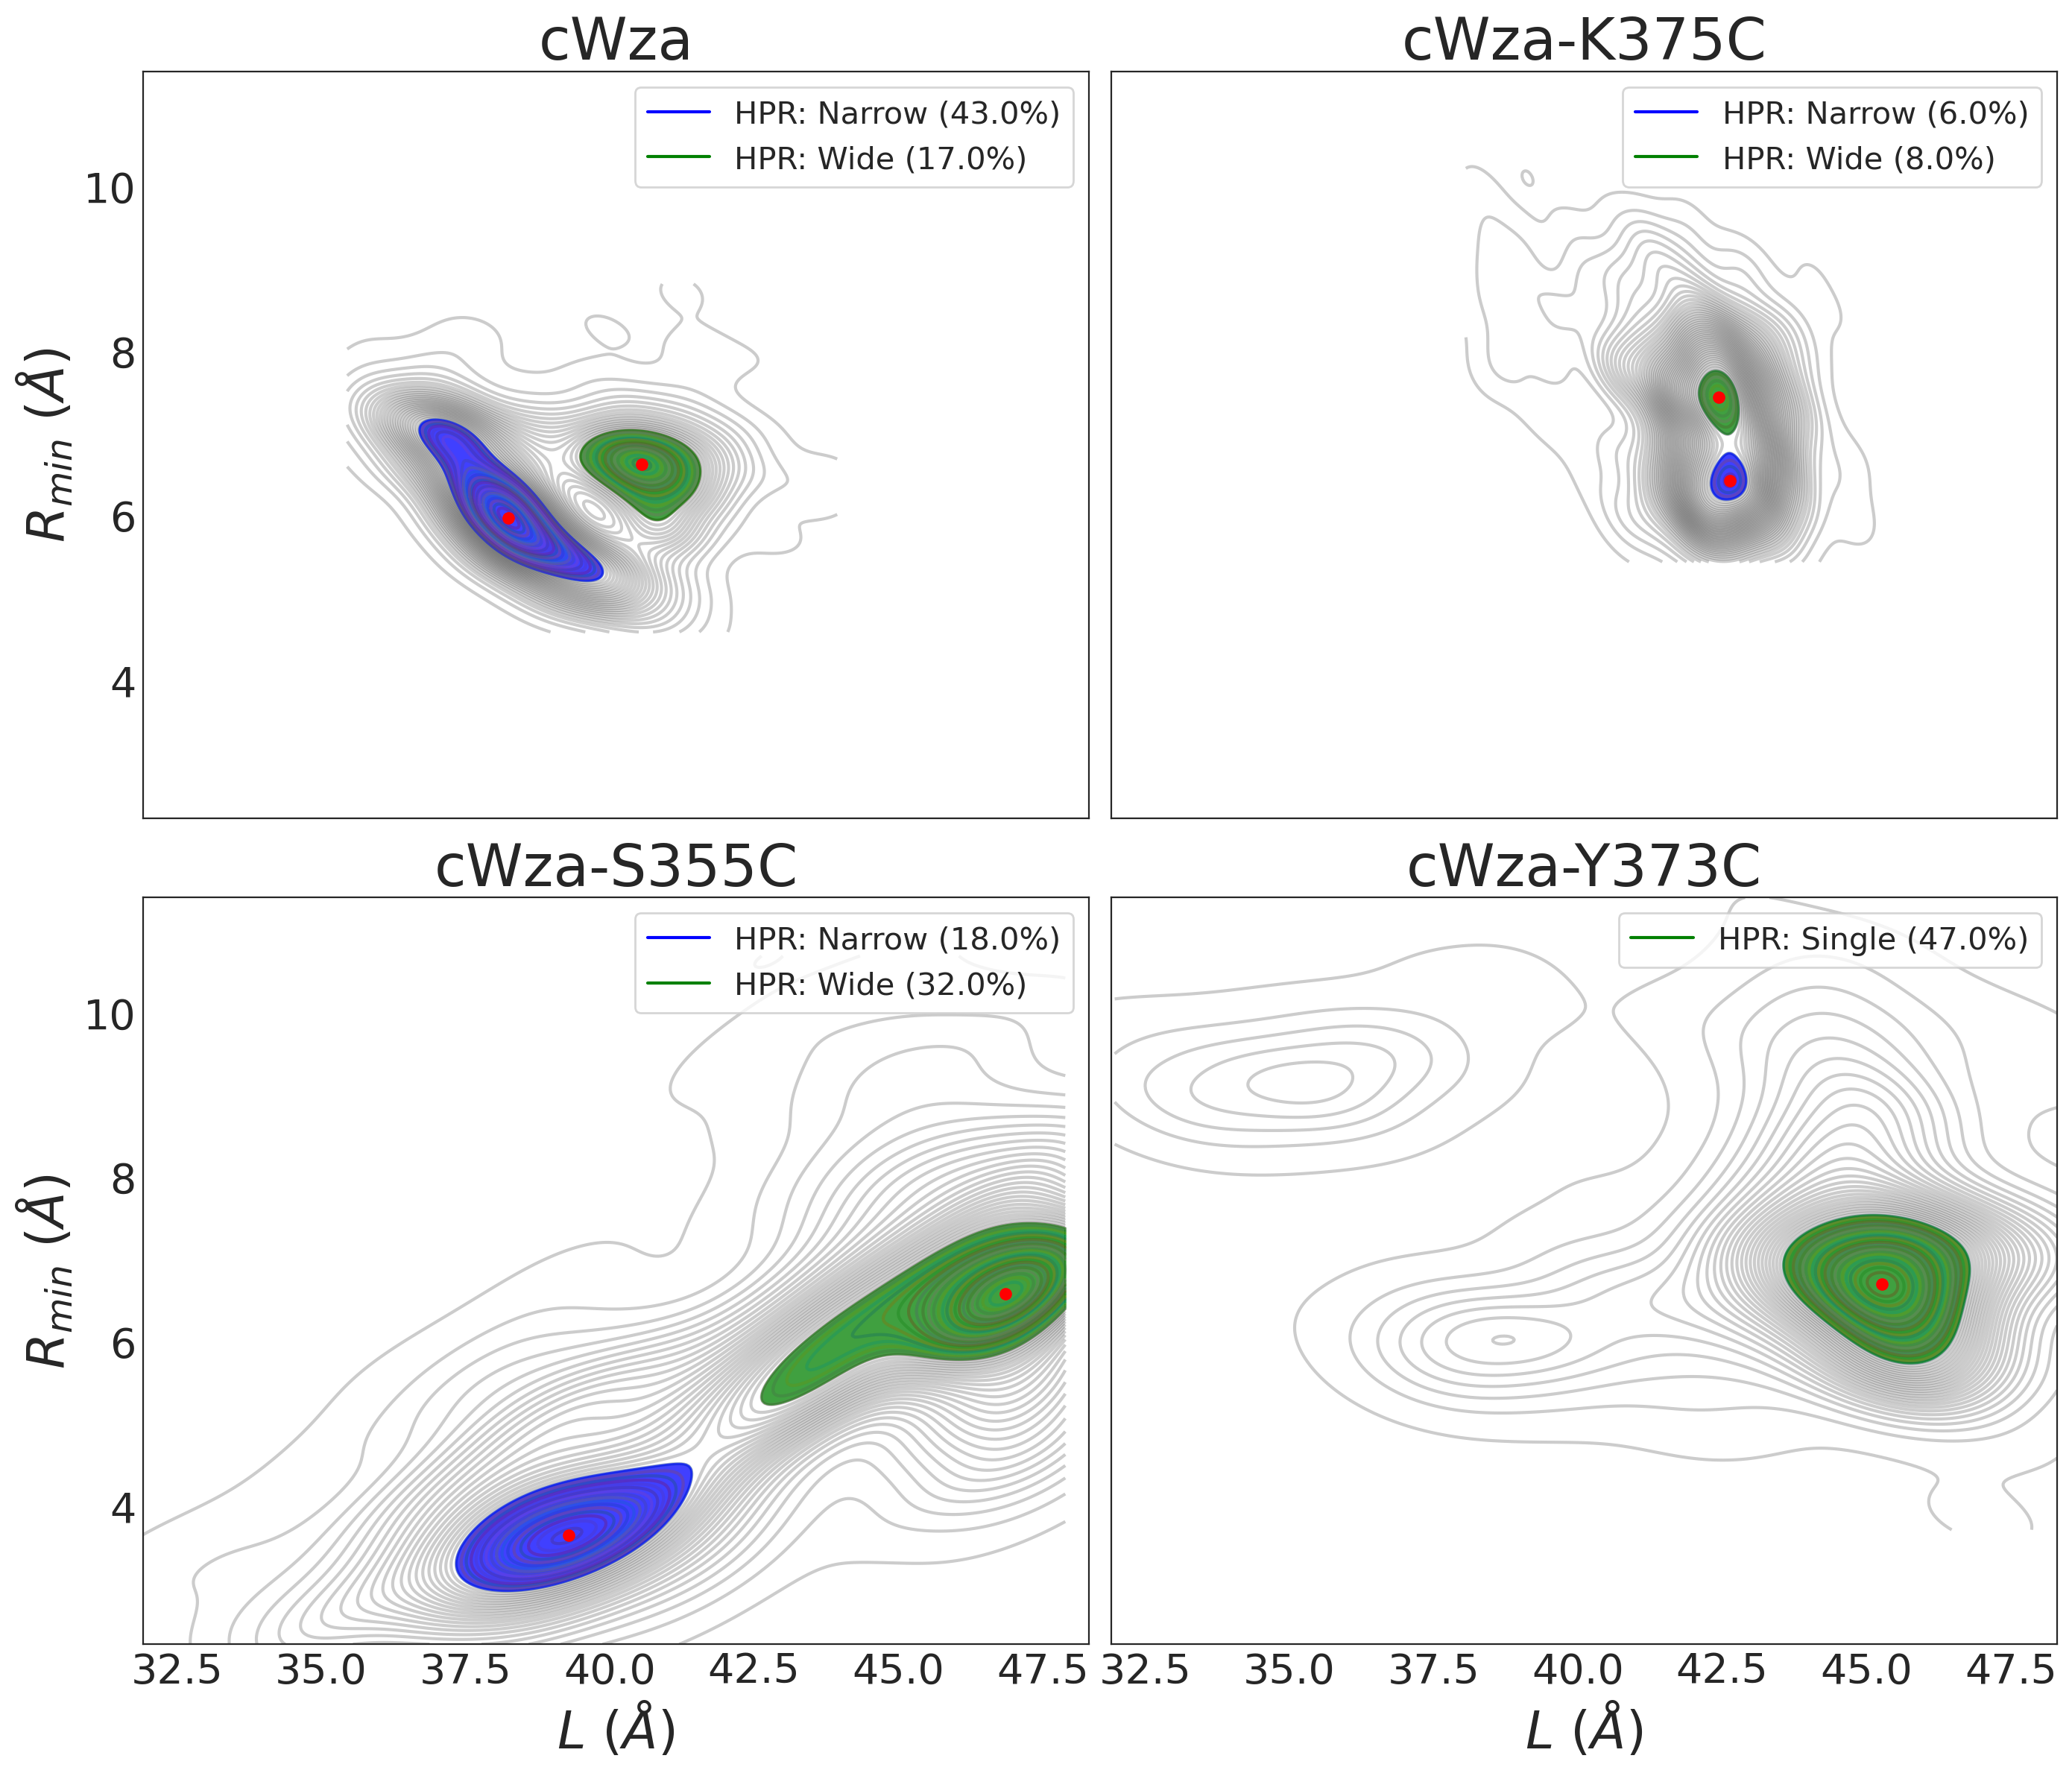

In [11]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

sns.set_style("white")
fig, ax = plt.subplots(2,2, figsize=(14,12),dpi=200,sharex=True,sharey=True)


axes = {
    'cWza':ax[0,0],
    'cWza-K375C':ax[0,1],
    'cWza-S355C':ax[1,0],
    'cWza-Y373C':ax[1,1]
}

labels = {
    'cWza':("","$R_{min}$ ($\AA$)",""),
    'cWza-K375C':("","","probability density"),
    'cWza-S355C':("$L$ ($\AA$)","$R_{min}$ ($\AA$)",""),
    'cWza-Y373C':("$L$ ($\AA$)","","probability density")
}

Conformations = {
    'cWza':['Narrow', 'Wide'],
    'cWza-K375C':['Narrow', 'Wide'],
    'cWza-S355C':['Narrow', 'Wide'],
    'cWza-Y373C':['Single']
}

Colors = {
    'Narrow': 'blue',
    'Wide': 'green',
    'Single': 'green'
}

Contours_filtred = {}
Contours_mutants = {}
ContoursProb_filtred = {}
Filtered_Indices = {}
ff = 0.5 # filtering factor

for i in range(n_mutants):
    mutant = mutant_names[i]
    Contours_filtred[mutant] = {}
    Contours_mutants[mutant] = []
    ContoursProb_filtred[mutant] = {}
    ###############################################
    # Extract DB data
    ###############################################
    key11,key12 = 'vdw metrics','length'
    key21,key22 = 'vdw metrics','min'
    X1 = [ S_mutants[mutant][id][key11][key12] for id in S_mutants[mutant].keys()]
    X2 = [ S_mutants[mutant][id][key21][key22] for id in S_mutants[mutant].keys()]
    ###############################################
    # Stuff for filtering models IDs
    ###############################################
    Filtered_Indices[mutant] = {}
    N_models = len(S_mutants[mutant].keys())
    Points = [Point(X1[n],X2[n]) for n in range(N_models)]
    ###############################################
    # Estimate PDF and set levels for contour plot
    ###############################################
    kde = gaussian_kde([X1,X2])
    Z = kde([X1,X2])
    pdf_max = max(Z)
    pdf_min = min(Z)
    n_contours = 50
    levels = numpy.linspace(pdf_min, pdf_max,n_contours)
    ###############################################
    # Draw all contour plots as black transparent background
    ###############################################
#     axes[mutant].scatter(X1,X2,color='black',alpha=0.1)
    Xc,Yc,Zc = list( density_estimation(X1,X2) )
    CS = axes[mutant].contour(Xc,Yc,Zc,levels,colors='k',alpha=0.2,zorder=0)
    ###############################################
    maxima = maxima_mutants[mutant]
    n_maxima = len(maxima)
    maxima_indices = [(i,list(set(range(n_maxima))-set([i]))) for i in list(set(range(n_maxima)))]
        
    for n in range(n_maxima):
#         conf = Conformations[mutant][n]
        # Indeces of main maximum to isolate and remaining maxima
        n0,other_indices = maxima_indices[n]
        Contours_filtred[mutant][n0] = []
        ContoursProb_filtred[mutant][n0] = []
        point0 = Point(maxima[n0])
        other_points = [Point(maxima[n1]) for n1 in other_indices]
        # 
        peak0_height = kde(maxima[n0])[0]
    #     print(maxima[n0],peak0_height)
        x,y = maxima[n0]
#         axes[mutant].scatter(x,y,s=50,color='red',zorder=10)
        for l in range(len(CS.allsegs)):
            prob = CS.levels[l]
            for k in range(len(CS.allsegs[l])):
                # Extract contour line coordinates
                CS_coords = CS.allsegs[l][k]
                Contours_mutants[mutant].append(CS_coords)
                # Turn contour line into Polygon
                polygon = Polygon(CS_coords)
                # Check if maximum within contour line
                if polygon.contains(point0):
                    if all([not polygon.contains(point) for point in other_points]):
                        if prob > ff*peak0_height:
                            Contours_filtred[mutant][n0].append(CS_coords)
                            ContoursProb_filtred[mutant][n0].append(prob)
                            CS_coords = CS_coords.T
                            axes[mutant].plot(CS_coords[0],CS_coords[1],alpha=0.2,zorder=5)
    ###############################################                            
    # Customise plot
    ###############################################
    axes[mutant].set_title(mutant, fontsize=28)
    axes[mutant].tick_params(axis='both',direction='in',labelsize=20)
    l1,l2,l3 = labels[mutant]
    axes[mutant].set_xlabel(l1,fontsize=25)
    axes[mutant].set_ylabel(l2,fontsize=25)
    ###############################################
    # Fill regions of HP and show maxima
    ###############################################
    for n in range(n_maxima):
        x,y = maxima_mutants[mutant][n]
        axes[mutant].scatter(x,y,s=25,color='red',zorder=10)
        X,Y = Contours_filtred[mutant][n][0].T
        ###############################################
        # Count models
        ###############################################
        polygon = Polygon(Contours_filtred[mutant][n][0])
        Filtered_Indices[mutant][n] = [k for k in range(N_models) if polygon.contains(Points[k])]
        ###############################################
        if max(ContoursProb_filtred[mutant][n]) > 0.02:
            c = Colors[Conformations[mutant][n]]
            axes[mutant].fill(X,Y,color=c,alpha=0.75)
            C_name = Conformations[mutant][n] # Conformation name
            N_models_C = len(Filtered_Indices[mutant][n]) # No models per conformation
            Percentage = numpy.floor(100*(N_models_C/N_models)) # Percentage
            # Add legend box
            axes[mutant].plot([],[],label='HPR: '+C_name+' ('+str(Percentage)+'%)',color=c)
    ###############################################
    axes[mutant].legend(loc='best',fontsize=15)

# axes[mutant].set_xlim(35,50)
# axes[mutant].set_ylim(2,10)

plt.tight_layout()
plt.show()